# Clustering of polygons

### Problem:

*Given a set of polygons, how do we efficiently recover one aggregate shape containing the region where **n** shapes overlapped?*

First, say the jupyter magic words 🧙‍

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import the plethora of useful modules we'll need (including some we probably don't)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from itertools import combinations
from shapely.geometry import Polygon, MultiPolygon
from shapely.affinity import translate
from shapely.ops import unary_union

Create some test shapes

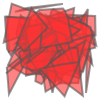

In [3]:
shapes = MultiPolygon([
    translate(
        Polygon([
            np.random.random(size=2)*5
            for i in range(np.random.randint(5) + 3)
        ]).convex_hull,
        xoff=np.random.randint(5),
        yoff=np.random.randint(5)
    )
    for i in range(50)
])
shapes

(0, 10)

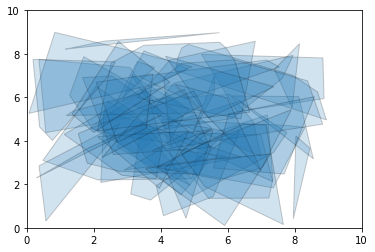

In [4]:
for poly in shapes:
    plt.gca().add_patch(PolygonPatch(poly, alpha=0.2))
        
plt.xlim(0, 10); plt.ylim(0, 10)

Make a 2d array of all intersections of objects

In [5]:
intersections_pass1 = [
    m.intersection(n)
    for i, m in enumerate(shapes)
    for n in shapes[i+1:]
]
grid_pass1 = np.zeros((len(shapes), len(shapes)), dtype=object)


upper_indices = np.triu_indices(len(shapes), k=1)
lower_indices = np.tril_indices(len(shapes), k=-1)

grid_pass1[upper_indices] = [
    m.intersection(n)
    for i, m in enumerate(shapes)
    for n in shapes[i+1:]
]
grid_pass1[lower_indices] = grid_pass1.T[lower_indices]

We'll also make a 2d array of intersection areas (coz we can)

In [6]:
areas_pass1 = np.zeros((len(shapes), len(shapes)), dtype=object)
areas_pass1[upper_indices] = [i.area for i in intersections_pass1]
areas_pass1[lower_indices] = areas_pass1.T[lower_indices]

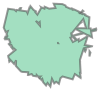

In [7]:
out = Polygon()
for i, j, k, l in list(combinations(range(len(shapes)), 4)):
    zero_patch = any((
        grid_pass1[i, j].area == 0,
        grid_pass1[i, k].area == 0,
        grid_pass1[i, l].area == 0,
        grid_pass1[j, k].area == 0,
        grid_pass1[j, l].area == 0,
        grid_pass1[l, k].area == 0,
    ))
    if not zero_patch:
        four_poly = grid_pass1[i, j].intersection(grid_pass1[k, l])
        if four_poly.area != 0:
            out = out.union(four_poly)
out

(-0.3788489077893095,
 9.389870689747017,
 -0.34095222745360154,
 9.433885297429068)

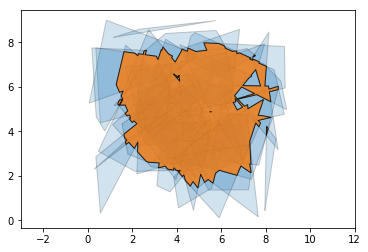

In [8]:
for poly in shapes:
    plt.gca().add_patch(PolygonPatch(poly, alpha=0.2))
plt.gca().add_patch(PolygonPatch(out, alpha=0.8, fc='C1'))
plt.xlim(0, 10); plt.ylim(0, 10)
plt.axis('equal')